In [9]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torch.fft import fft2, fftshift

In [10]:
class LowPassFilter(torch.nn.Module):
    def __init__(self, rows, cols) -> None:
        super(LowPassFilter, self).__init__()
        self.rows = rows
        self.cols = cols
    
    def forward(self, radius):
        crow, ccol = self.rows // 2 , self.cols // 2
        low_pass = torch.zeros((self.rows, self.cols), dtype=torch.uint8)
        x = torch.arange(0, self.cols).unsqueeze(0).expand(self.rows, self.cols)
        y = torch.arange(0, self.rows).unsqueeze(1).expand(self.rows, self.cols)
        mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius**2
        low_pass[mask_area] = 1
        # low_pass[:, 49:79] = 1
        return low_pass

# class LowPassFilter(torch.nn.Module):
#     def __init__(self, rows, cols) -> None:
#         super(LowPassFilter, self).__init__()
#         self.rows = rows
#         self.cols = cols
    
#     def forward(self, radius):
#         crow, ccol = self.rows // 2 , self.cols // 2
#         low_pass = torch.zeros((self.rows, self.cols), dtype=torch.uint8)
#         x = torch.arange(0, self.cols).unsqueeze(0).expand(self.rows, self.cols)
#         y = torch.arange(0, self.rows).unsqueeze(1).expand(self.rows, self.cols)
#         mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius**2

#         delta = radius // 2
#         mid = self.cols // 2
#         start = max(mid - delta, 0)
#         end = min(mid + delta, self.cols)
#         low_pass[:, start:end ] = 1

#         return low_pass

In [11]:
class Fourier(torch.nn.Module):
    def __init__(self):
        super(Fourier, self).__init__()

    def forward(self, image):
        im_fourier = fftshift(fft2(image))
        return im_fourier, torch.log(torch.abs(im_fourier) + 1)

In [12]:
class ClippedFourier(torch.nn.Module):
    def __init__(self, im_max=1.0, low_pass_radius=25, im_size=(128, 128)):
        super(ClippedFourier, self).__init__()
        self.im_max = torch.tensor(im_max)
        self.threshold = low_pass_radius
        self.low_pass = LowPassFilter(im_size[0], im_size[1])

    def forward(self, image):
        im_fourier = fftshift(fft2(image)) * self.low_pass(self.threshold)
        return im_fourier, torch.log(torch.abs(im_fourier) + 1)

In [13]:
def plot_im(im, title, color='inferno'):
    plt.imshow(im, cmap=color)
    plt.axis('off')
    plt.show()
    plt.clf()
    print(title)

In [14]:
mse = nn.MSELoss()

def fourier_psnr(im1, im2):
    n_pixels = im1.shape[0] * im1.shape[1]
    sum_sq_error = torch.sum(torch.abs(im1 - im2) ** 2)
    psnr = 20 * torch.log10(torch.tensor(1.0) * n_pixels) - 10 * torch.log10(sum_sq_error)
    return psnr.item()

def spatial_psnr(im1, im2): 
    return 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse(im1, im2))

In [15]:
path = "/groups/turaga/home/troidlj/neural-volumes/logs/hemibrain-unfold-attempt_paper/results_iteration_2_900_ep_paper/16431_16790_19533.npy/result/xz_51_20_92440414428711.png"
reconstruction = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
reconstruction = reconstruction.float()
reconstruction = (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())

path = "/groups/turaga/home/troidlj/neural-volumes/logs/hemibrain-unfold-attempt_paper/results_iteration_2_900_ep_paper/16431_16790_19533.npy/gt/xz_51.png"
gt = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
gt = gt.float()
gt = (gt - gt.min()) / (gt.max() - gt.min())

path = "/groups/turaga/home/troidlj/neural-volumes/logs/hemibrain-unfold-attempt_paper/results_iteration_2_900_ep_paper/16431_16790_19533.npy/bilinear/xz_51_20_297225952148438.png"
baseline = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
baseline = baseline.float()
baseline = (baseline - baseline.min()) / (baseline.max() - baseline.min())


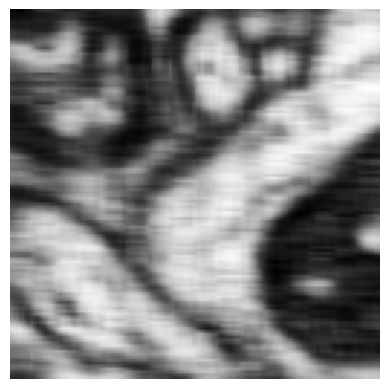

Reconstruction


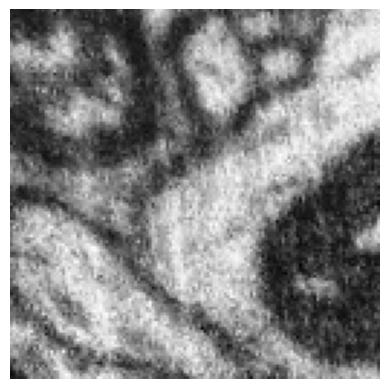

Ground Truth


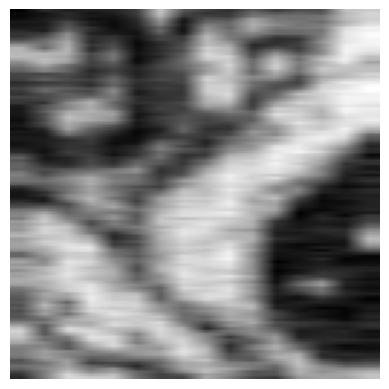

Bilinear


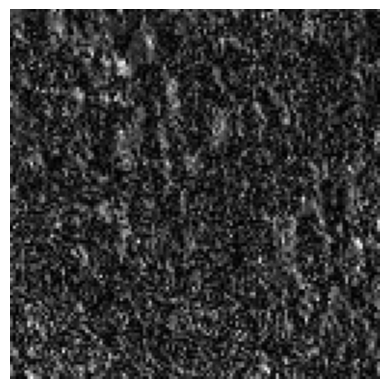

Reconstruction Abs Error


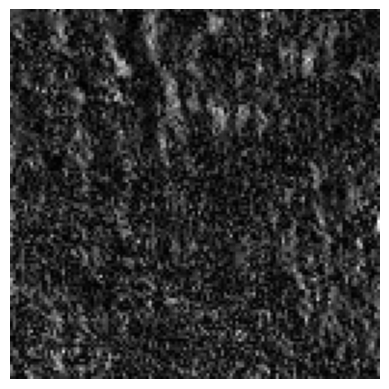

Bilinear Abs Error


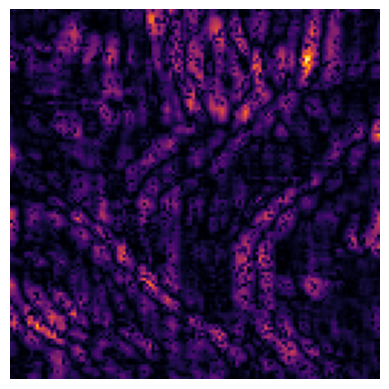

Error Difference
Reconstruction MSE in Spatial Domain: 0.008626356720924377
Reconstruction PSNR in Spatial Domain: 20.641725540161133
Bilinear MSE in Spatial Domain: 0.010139495134353638
Bilinear PSNR in Spatial Domain: 19.939836502075195


<Figure size 640x480 with 0 Axes>

In [16]:
plot_im(reconstruction, "Reconstruction", color="grey")
plot_im(gt, "Ground Truth", color="grey")
plot_im(baseline, "Bilinear", color="grey")
err_reconstr = torch.abs(reconstruction - gt)
err_baseline = torch.abs(baseline - gt)
plot_im(err_reconstr, "Reconstruction Abs Error", color="grey")
plot_im(err_baseline, "Bilinear Abs Error", color="grey")
plot_im(torch.abs(err_reconstr - err_baseline), "Error Difference")

print("Reconstruction MSE in Spatial Domain: {}".format(mse(reconstruction, gt)))
print("Reconstruction PSNR in Spatial Domain: {}".format(spatial_psnr(reconstruction, gt)))

print("Bilinear MSE in Spatial Domain: {}".format(mse(baseline, gt)))
print("Bilinear PSNR in Spatial Domain: {}".format(spatial_psnr(baseline, gt)))


In [17]:
fourier = Fourier()

reconstruction_fourier, recon_fourier_display = fourier(reconstruction)
gt_fourier, gt_fourier_display = fourier(gt)
baseline_fourier, baseline_fourier_display = fourier(baseline)


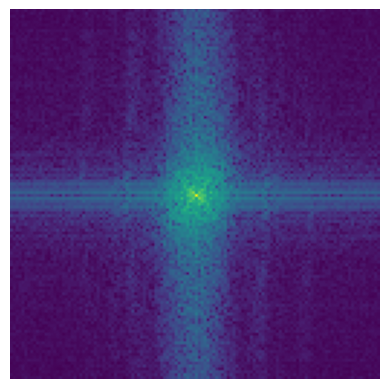

Reconstruction Fourier


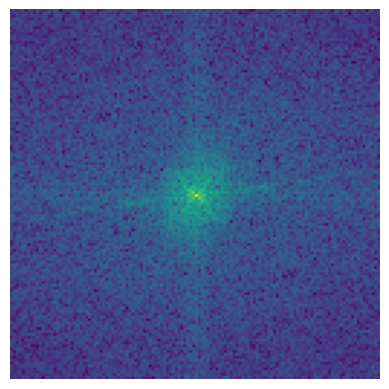

Ground Truth Fourier


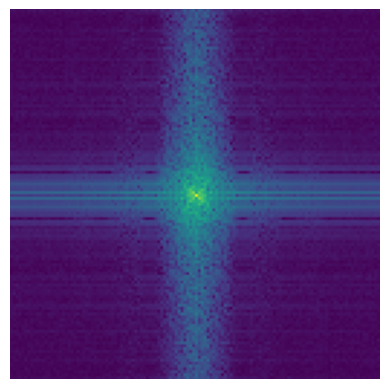

Bilinear Fourier


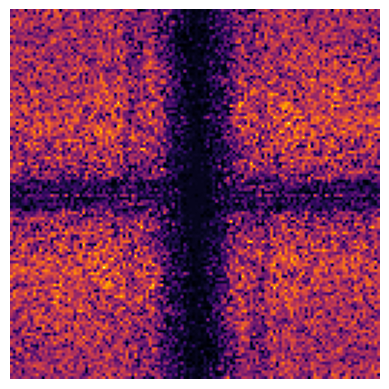

Reconstruction Abs Error Fourier


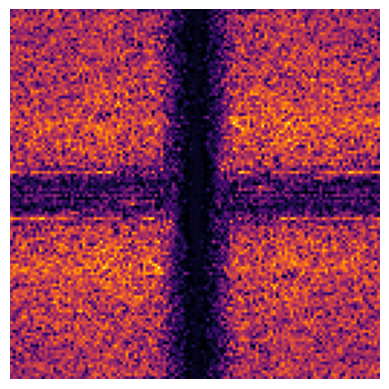

Bilinear Abs Error Fourier


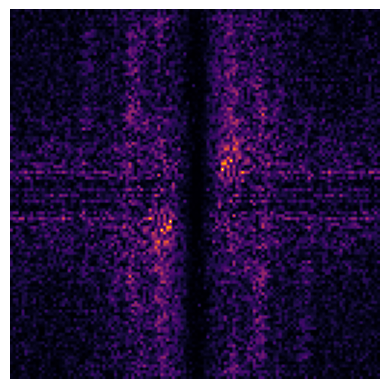

Error Difference Fourier
MSE in Fourier: 0.008626354858279228
PSNR in Fourier: 20.6417236328125
MSE in Fourier for Bilinear: 0.01013948954641819
PSNR in Fourier for Bilinear: 19.939842224121094


<Figure size 640x480 with 0 Axes>

In [18]:
plot_im(recon_fourier_display, "Reconstruction Fourier", color='viridis')
plot_im(gt_fourier_display, "Ground Truth Fourier", color='viridis')
plot_im(baseline_fourier_display, "Bilinear Fourier", color='viridis')

recon_error = torch.abs(recon_fourier_display - gt_fourier_display)
baseline_error = torch.abs(baseline_fourier_display - gt_fourier_display)

plot_im(recon_error, "Reconstruction Abs Error Fourier")
plot_im(baseline_error, "Bilinear Abs Error Fourier")
plot_im(torch.abs(recon_error - baseline_error), "Error Difference Fourier")

n_pixels = reconstruction_fourier.shape[0] * reconstruction_fourier.shape[1]
mse_fourier = torch.mean(torch.abs(reconstruction_fourier - gt_fourier) ** 2) / n_pixels
mse_baseline_fourier = torch.mean(torch.abs(baseline_fourier - gt_fourier) ** 2) / n_pixels

print("MSE in Fourier: {}".format(mse_fourier.item()))
print("PSNR in Fourier: {}".format(fourier_psnr(reconstruction_fourier, gt_fourier)))

print("MSE in Fourier for Bilinear: {}".format(mse_baseline_fourier.item()))
print("PSNR in Fourier for Bilinear: {}".format(fourier_psnr(baseline_fourier, gt_fourier)))

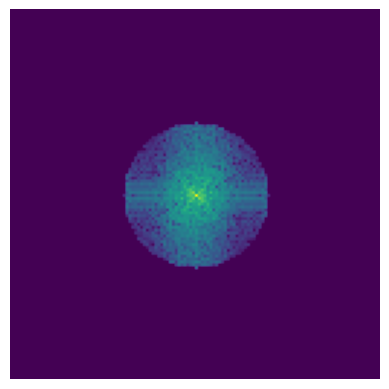

Reconstruction Clipped Fourier


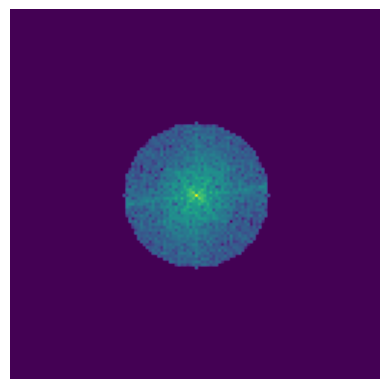

Ground Truth Clipped Fourier


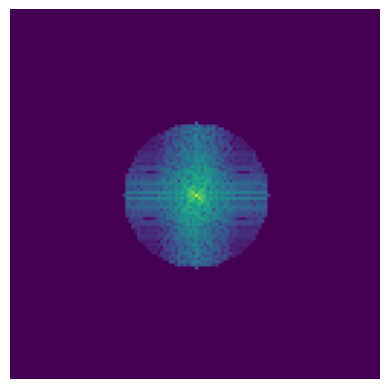

Bilinear Clipped Fourier


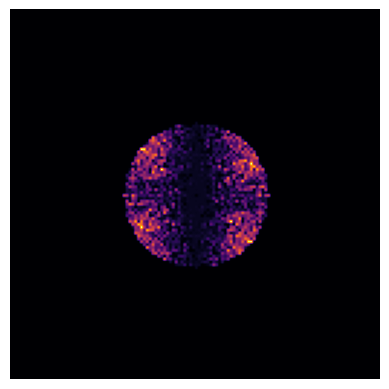

Abs Error Clipped Fourier


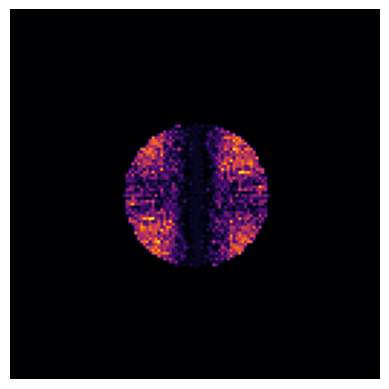

Bilinear Abs Error Clipped Fourier


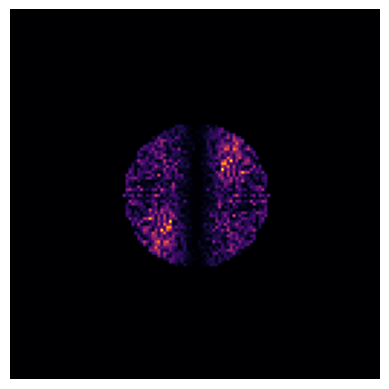

Error Difference Clipped Fourier
MSE in Clipped Fourier: 0.0048403991386294365
PSNR in Clipped Fourier: 23.15119171142578
MSE in Clipped Fourier for Bilinear: 0.006329956464469433
PSNR in Clipped Fourier for Bilinear: 21.985992431640625


<Figure size 640x480 with 0 Axes>

In [19]:
clipped_fourier = ClippedFourier()

reconstruction_cf_fourier, rec_fourier_display = clipped_fourier(reconstruction)
gt_cf_fourier, gt_fourier_display = clipped_fourier(gt)
bs_cf_fourier, bs_fourier_display = clipped_fourier(baseline)

plot_im(rec_fourier_display, "Reconstruction Clipped Fourier", color='viridis')
plot_im(gt_fourier_display, "Ground Truth Clipped Fourier", color='viridis')
plot_im(bs_fourier_display, "Bilinear Clipped Fourier", color='viridis')

recon_error_cf = torch.abs(rec_fourier_display - gt_fourier_display)
baseline_error_cf = torch.abs(bs_fourier_display - gt_fourier_display)

plot_im(recon_error_cf, "Abs Error Clipped Fourier")
plot_im(baseline_error_cf, "Bilinear Abs Error Clipped Fourier")
plot_im(torch.abs(recon_error_cf - baseline_error_cf), "Error Difference Clipped Fourier")

mse_cf_fourier = torch.mean(torch.abs(reconstruction_cf_fourier - gt_cf_fourier) ** 2) / n_pixels
mse_baseline_cf_fourier = torch.mean(torch.abs(bs_cf_fourier - gt_cf_fourier) ** 2) / n_pixels

print("MSE in Clipped Fourier: {}".format(mse_cf_fourier.item()))
print("PSNR in Clipped Fourier: {}".format(fourier_psnr(reconstruction_cf_fourier, gt_cf_fourier)))

print("MSE in Clipped Fourier for Bilinear: {}".format(mse_baseline_cf_fourier.item()))
print("PSNR in Clipped Fourier for Bilinear: {}".format(fourier_psnr(bs_cf_fourier, gt_cf_fourier)))